fem-2d-simple
=============

`fem2dsimple` is a simple solver for the 2D Poisson equation over a rectangular domain with Dirichlet boundary conditions.

Minimal theory
--------------
The Poisson equation with Dirichlet boundary conditions is given by

\begin{align*}
\nabla^2 u(x,y) = f(x,y) \quad & \forall (x,y) \in \Omega := [0,L_x] \times [0,L_y], \\
u(x,y) = 0               \quad & \forall (x,y) \in \partial\Omega,
\end{align*}


where $f$ is the inhomogeneity and $u$ the unknown.  By means of partial integration and with the definition of a basis set $\{v_i\}$, the problem can be recast as a linear system,

$$
\sum_j A_{ij} u_j = b_i
$$

with $A_{ij} = \int_\Omega \nabla v_i(x,y) \; \nabla v_j(x,y) \; \mathrm d\sigma$, known as the *stiffness matrix*; and $b_i = \int_\Omega f(x,y) v_i(x,y) \; \mathrm d\sigma$.

`fem2dsimple` uses triangular elements to discretize the rectangular domain, and piece-wise linear polynomials as a basis-set.  Each basis function $v_i$ is defined in the neighborhood of the $i$-th node and is constrained to have compact support: namely, it equals 1 on the $i$-th node and vanishes on the neighbouring nodes.

Minimal example
---------------
To solve the Poisson equation with `fem2dsimple`, you need to specify your problem first: namely, you need to define the inhomogeneity $f(x,y)$.  Begin by defining your function of interest:

In [23]:
import numpy as np

# define a 2D gaussian function, p = [(x0,y0), (x1,y1), ...]
def f(p):
    sigma_x = 0.01
    sigma_y = 0.01
    x0      = 0.5
    y0      = 0.5
    N       = 1.0
    return N * np.exp(-((p[...,0]-x0)**2/(2.0*sigma_x) +
                        (p[...,1]-y0)**2/(2.0*sigma_y)))

To solve the problem defined by this function, import the `fem2d` module and create a mesh:

In [24]:
import fem2d as fem

Nx = 100    # number of rectangular mesh subdivisions in x
Ny = 100    # number of rectangular mesh subdivisions in y
Lx = 1.0    # x length of mesh rectangle
Ly = 1.0    # y length of mesh rectangle

# N.B.: each rectangular subdivision contains two elements (right-angled
# triangles), like so:
#
#  _ _!____!_ _
#     |   /|
#     |  / |
#     | /  |
#  _ _|/___|_ _
#     !    !

mesh = fem.TriangularMesh2D(Nx, Ny, Lx, Ly)
mesh.nodes

array([[0.  , 0.  ],
       [0.01, 0.  ],
       [0.02, 0.  ],
       ...,
       [0.98, 1.  ],
       [0.99, 1.  ],
       [1.  , 1.  ]])

Generate the coefficients matrix $A$ (i.e. the stiffness matrix) and the constants vector $b$ of the linear system:

In [25]:
A_mat = fem.stiffn(mesh)
b_vec = fem.fv_int(mesh, f)

Since $A$ is a banded matrix, `fem2d.stiffn` by default returns a matrix in [diagonal ordered form](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_banded.html), as accepted by the `scipy.linalg.solve_banded` solver:

In [26]:
A_mat

matrix([[ 0. ,  0. ,  0. , ..., -1. , -1. , -0.5],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [-0.5, -1. , -1. , ...,  0. ,  0. ,  0. ]])

Before solving the system efficiently with the `scipy.linalg.solve_banded` solver,  you need to retrieve the numbers of non-zero upper and lower diagonals of $A$.  The two happen to coincide ($A$ is symmetric) and be equal to the number of nodes in a row of the mesh, which is stored in the `fem2d.TriangularMesh2D` type as `nx`:

In [27]:
nx = mesh.nx
nx

101

Now you're all set to fire up `scipy.linalg.solve_banded`:

In [28]:
from scipy.linalg import solve_banded
u = solve_banded((nx,nx), A_mat, b_vec)

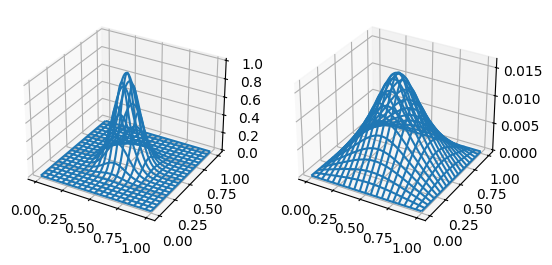

In [29]:
import matplotlib.pyplot as plt

# prepare (x,y) grid
nx, ny, nodes = mesh.nx, mesh.ny, mesh.nodes
X = nodes[:,0].reshape(nx,ny)
Y = nodes[:,1].reshape(nx,ny)

fig = plt.figure()

# first subplot: f(x, y), inhomogeneity of the Poisson equation
Z = f(nodes).reshape(nx,ny)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X, Y, Z, cstride=5, rstride=5)

# second subplot: x2, solution of the linear system
Z = u.reshape(nx,ny)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(X, Y, Z, cstride=5, rstride=5)